I'm going to have a quick go at making a deep learning version of the path finder.
The first thing to do will be to try to change efficientnet to have the correct input shape.

In [167]:
from __future__ import annotations
from pathlib import Path
from typing import *
from dataclasses import dataclass
import json
import random

import networkx as nx
import geffnet
from fastai.vision import *

In [5]:
model = geffnet.efficientnet_b0(as_sequential=True)

In [6]:
model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SwishJit()
  (3): Sequential(
    (0): DepthwiseSeparableConv(
      (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SwishJit()
      (se): SqueezeExcite(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (act1): SwishJit()
        (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): Identity()
    )
  )
  (4): Sequential(
    (0): InvertedResidual(
      (conv

So quickly reviewing this there is one immediate problem - the first convolution is stride 2.
That would crush the required resolution.
If I replace that layer with my desired shape and then make it stride 1 then it should be ok.

In [7]:
model[0] = nn.Conv2d(6, 32, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)

At this point it should be possible to pass a mock tensor through it to see if there are any problems.

In [8]:
with torch.no_grad():
    result = model(torch.rand(4, 49, 49, 6))

RuntimeError: Given groups=1, weight of size 32 6 3 3, expected input[4, 49, 49, 6] to have 6 channels, but got 49 channels instead

In [9]:
nn.Conv2d??

Init signature:
nn.Conv2d(
    in_channels,
    out_channels,
    kernel_size,
    stride=1,
    padding=0,
    dilation=1,
    groups=1,
    bias=True,
    padding_mode='zeros',
)
Source:        
class Conv2d(_ConvNd):
    r"""Applies a 2D convolution over an input signal composed of several input
    planes.

    In the simplest case, the output value of the layer with input size
    :math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
    can be precisely described as:

    .. math::
        \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
        \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


    where :math:`\star` is the valid 2D `cross-correlation`_ operator,
    :math:`N` is a batch size, :math:`C` denotes a number of channels,
    :math:`H` is a height of input planes in pixels, and :math:`W` is
    width in pixels.

    * :attr:`stride` controls the stride f

In [10]:
with torch.no_grad():
    result = model(torch.rand(4, 6, 49, 49))

In [11]:
result

tensor([[-0.1054,  0.0351, -0.0321,  ..., -0.2601, -0.0325, -0.2189],
        [-0.1275, -0.0481, -0.0368,  ..., -0.0999,  0.1180, -0.3013],
        [-0.0087,  0.1431, -0.0480,  ...,  0.0058,  0.0442, -0.0397],
        [-0.2344,  0.0512, -0.0798,  ..., -0.2245,  0.0429, -0.1096]])

Rookie mistake there.
It is `batch, channel, dimensions` rather than `batch, dimensions, channels`.
This just means I'll have to be a little more careful when creating the tensors from the mazes.

In [18]:
model[-1] = nn.Linear(in_features=1280, out_features=4, bias=True)
with torch.no_grad():
    result = model(torch.rand(4, 6, 49, 49))
result

tensor([[ 0.0731,  0.2863,  0.2112, -0.0165],
        [-0.1207,  0.2339,  0.0204, -0.0056],
        [-0.1080,  0.2230,  0.1111, -0.1869],
        [ 0.0825,  0.3305, -0.1610, -0.0936]])

So this looks good.
4 predictions for each "maze" in the batch.
I'll use sigmoid when doing the loss as that will produce better nll loss.

Now I can start trying to actually turn the mazes into tensors.
Lets get the graph stuff out of the way so I can have a nice loss function.

In [21]:
def calculate_direction(maze: Dict[str, Any]) -> str:
    pony = maze["pony"][0]
    end = maze["end-point"][0]
    width, _ = maze["size"]

    G = maze_to_graph(maze)
    idx_steps = nx.astar_path(G, pony, end)
    assert len(idx_steps) > 1
    return to_direction(idx_steps[0], idx_steps[1], width)

def maze_to_graph(maze: Dict[str, Any]) -> nx.Graph:
    G = nx.Graph()
    G.add_nodes_from(range(len(maze['data'])))
    width, _ = maze["size"]
    G.add_edges_from([
        (idx, idx - width)
        for idx, node in enumerate(maze['data'])
        if "north" not in node
    ])
    G.add_edges_from([
        (idx, idx - 1)
        for idx, node in enumerate(maze['data'])
        if "west" not in node
    ])
    return G

def to_direction(start: int, end: int, width: int) -> str:
    assert start != end
    if start > end: # left or up
        if start - end == 1: # left
            return "west"
        assert start - end == width
        return "north"
    if end - start == 1:
        return "east"
    assert end - start == width
    return "south"

In [195]:
NORTH_IDX = 0
EAST_IDX = 1
SOUTH_IDX = 2
WEST_IDX = 3
IS_EXIT_IDX = 4
IS_ENEMY_IDX = 5

def maze_to_tensor(maze: Dict[str, Any]) -> torch.Tensor:
    """
    The input would be the maze, redefined as a 3 dimensional tensor.
    The channel dimension would be (wall_north, wall_east, wall_south, wall_west, is_exit, is_enemy).
    The other two dimensions would be the X and Y of the maze cells.
    The maze would always be centered on the pony, so considering that the maze can be 25x25 this would be a 6x49x49 tensor.
    Areas outside the maze would be considered to have walls in all directions and would never contain an exit or an enemy.
    """
    width, height = maze["size"]
    
    def to_x(idx: int) -> int:
        return idx % width
    def to_y(idx: int) -> int:
        return idx // width

    # if pony is at 0 on a dimension then the cells of the maze are from 25 to (25+dim)
    # if the pony is at w on a dimension then the cells of the maze are from (25-dim) to 25
    x_offset, y_offset = 24 - to_x(maze["pony"][0]), 24 - to_y(maze["pony"][0])

    # initialize the tensor with walls in all directions and no exit or enemy
    tensor = torch.ones(6, 49, 49)
    tensor[[IS_EXIT_IDX,IS_ENEMY_IDX],:,:] = 0

    for idx, cell in enumerate(maze["data"]):
        x_base, y_base = to_x(idx), to_y(idx)
        x, y = x_offset + x_base, y_offset + y_base

        if "north" not in cell:
            tensor[NORTH_IDX, x, y] = 0
        if "west" not in cell:
            tensor[WEST_IDX, x, y] = 0
        if x_base < (width - 1) and "west" not in maze["data"][idx + 1]:
            tensor[EAST_IDX, x, y] = 0
        if y_base < (height - 1) and "north" not in maze["data"][idx + width]:
            tensor[SOUTH_IDX, x, y] = 0
    enemy_x, enemy_y = x_offset + to_x(maze["domokun"][0]), y_offset + to_y(maze["domokun"][0])
    exit_x, exit_y = x_offset + to_x(maze["end-point"][0]), y_offset + to_y(maze["end-point"][0])
    
    tensor[IS_ENEMY_IDX, enemy_x, enemy_y] = 1
    tensor[IS_EXIT_IDX, exit_x, exit_y] = 1
    
    return tensor

In [44]:
MAZE_FILE = Path('data/w15-h15-d0/b1db795c-1747-4889-bfa9-fcf1749dadfb/0000.json')
raw_data = json.loads(MAZE_FILE.read_text())

In [45]:
maze_to_tensor(raw_data)[:, 24, 17]

tensor([1., 0., 1., 1., 0., 0.])

In [47]:
maze_tensor = maze_to_tensor(raw_data)
direction = calculate_direction(raw_data)
direction

'west'

In [49]:
with torch.no_grad():
    result = nn.Sigmoid()(model(maze_tensor[None, :]))
result

tensor([[0.4977, 0.5684, 0.5103, 0.4808]])

This is currently picking east, although it is all quite close:

```
tensor([[0.4977, 0.5684, 0.5103, 0.4808]])
(north, east, south, west)
```

It should be picking west.
Lets try training it on this one thing just once.
I am going to use [CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss) for this.
Then I can fit it into fastai for proper training.

In [50]:
model = model.train()
result = nn.Sigmoid()(model(maze_tensor[None, :]))

In [68]:
target = torch.tensor([WEST_IDX], dtype=torch.long)

In [69]:
result, target

(tensor([[0.4977, 0.5684, 0.5103, 0.4808]], grad_fn=<SigmoidBackward>),
 tensor([3]))

In [70]:
loss = nn.CrossEntropyLoss()
output = loss(result, target)
output

tensor(1.4203, grad_fn=<NllLossBackward>)

In [71]:
output.backward()

In [72]:
with torch.no_grad():
    result = nn.Sigmoid()(model(maze_tensor[None, :]))
result

tensor([[0.4977, 0.5684, 0.5103, 0.4808]])

I need an optimizer to actually change the results...

In [86]:
optimizer = optim.Adam(model.parameters(), lr=3e-3)
optimizer.zero_grad()
result = nn.Sigmoid()(model(maze_tensor[None, :]))
output = loss(result, target)
output.backward()
optimizer.step()

In [87]:
with torch.no_grad():
    result = nn.Sigmoid()(model(maze_tensor[None, :]))
result

tensor([[0.3019, 0.3676, 0.3169, 0.6839]])

That was pretty straightforward.
Now I should try to load this into the fastai framework.

The main tasks for this are:

 * Create a method to create the model with the patched input (fastai will adjust the head)
 * Create a data bunch for the mazes

After getting that working I can create an augmentation strategy for the mazes.

In [89]:
def make_model(pretrained: bool = False) -> nn.Module:
    assert not pretrained
    model = geffnet.efficientnet_b0(as_sequential=True)
    model[0] = nn.Conv2d(6, 32, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
    return model.train()

Now I need to create my custom DataBunch.
I'm going to follow [this tutorial](https://docs.fast.ai/tutorial.itemlist.html) which seems reasonably straightforward:

 * ItemBase = single maze & direction
 * ItemList = bunch of mazes


In [99]:
DIRECTION_TO_IDX = {
    "north": NORTH_IDX,
    "east": EAST_IDX,
    "south": SOUTH_IDX,
    "west": WEST_IDX,
}

@dataclass
class Maze(ItemBase):
    data: torch.Tensor
    label: int

    @staticmethod
    def from_path(path: Path) -> Maze:
        return Maze.from_dict(json.loads(path.read_text()))

    @staticmethod
    def from_dict(maze: Dict[str, Any]) -> Maze:
        data = maze_to_tensor(maze)
        direction = calculate_direction(maze)
        label = DIRECTION_TO_IDX[direction]
        return Maze(data=data, label=label)

    def apply_tfms(self, tfms, **kwargs):
        print("Not implemented")
        return self

    def to_one(self):
        return self.data

In [122]:
def load_mazes(folder: Path) -> CategoryList:
    data = []
    labels = set()
    for file in folder.glob("*/*.json"):
        maze = Maze.from_path(file)
        data.append(maze)
        labels.add(maze.label)
    return CategoryList(items=data, classes=labels)

In [123]:
mazes = load_mazes(Path("data/w15-h15-d0"))

In [124]:
valid_mazes = load_mazes(Path("data/w25-h25-d10"))

In [125]:
len(mazes), len(valid_mazes)

(254, 123)

In [128]:
data = DataBunch.create(mazes, valid_mazes)

AttributeError: 'CategoryList' object has no attribute 'y'

In [127]:
mazes.classes

{0, 1, 2, 3}

So I think that the documentation is confusing.
The CategoryList appears to be a list of labels for each of the items.
Lets try just creating a Dataset.

In [141]:
class ArrayDataset(Dataset):
    @staticmethod
    def from_folder(folder: Path) -> ArrayDataset:
        data = []
        labels = []
        for file in folder.glob("*/*.json"):
            maze = Maze.from_path(file)
            data.append(maze.data)
            labels.append(maze.label)
        return ArrayDataset(data, labels)
    
    def __init__(self, x: List[torch.Tensor], y: List[int]):
        self.x, self.y = x, y
        self.classes = sorted(set(y))
        self.c = len(self.classes)
    
    def __len__(self) -> int:
        return len(self.x)
    
    def __getitem__(self, i) -> Tuple[torch.Tensor, int]:
        return self.x[i], self.y[i]
    
    def __repr__(self):
        return f"ArrayDataset(x.shape={self.x[0].shape}, c={self.c}, classes={self.classes})"

In [142]:
mazes = ArrayDataset.from_folder(Path("data/w15-h15-d0"))
valid_mazes = ArrayDataset.from_folder(Path("data/w25-h25-d10"))

In [143]:
data = DataBunch.create(mazes, valid_mazes)

In [144]:
data

DataBunch;

Train: ArrayDataset(x.shape=torch.Size([6, 49, 49]), c=4, classes=[0, 1, 2, 3]);

Valid: ArrayDataset(x.shape=torch.Size([6, 49, 49]), c=4, classes=[0, 1, 2, 3]);

Test: None

In [146]:
learner = Learner(data, make_model())

In [148]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


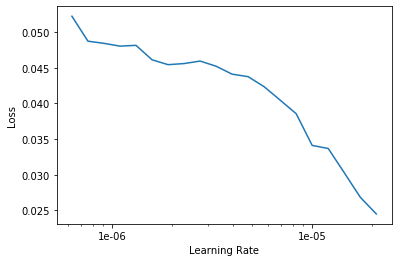

In [149]:
learner.recorder.plot()

In [152]:
learner.fit_fc(4, lr=3e-3)

So I've broken it badly already.
The loss function is incorrect?

In [153]:
learner.loss_func

<function torch.nn.functional.nll_loss(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')>

So I really want cross entropy, which is a more specific form of nll.
Reviewing the model to check the head might be appropriate at this point as well.

In [154]:
learner.model

Sequential(
  (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SwishJit()
  (3): Sequential(
    (0): DepthwiseSeparableConv(
      (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SwishJit()
      (se): SqueezeExcite(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (act1): SwishJit()
        (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): Identity()
    )
  )
  (4): Sequential(
    (0): InvertedResidual(
      (conv

So it hasn't adjusted the head of the model at all.
No problem, I can fix that in the creator.
The next thing would be to fix the loss function properly.

In [155]:
def make_model(pretrained: bool = False) -> nn.Module:
    assert not pretrained
    model = geffnet.efficientnet_b0(as_sequential=True)
    model[0] = nn.Conv2d(6, 32, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
    model[-1] = nn.Linear(in_features=1280, out_features=4, bias=True)
    return model.train()

In [157]:
learner = Learner(data, make_model(), loss_func=F.cross_entropy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


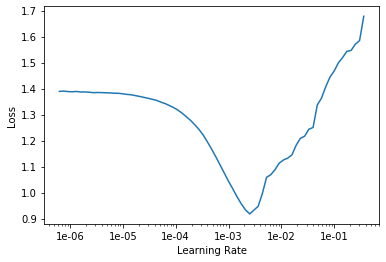

In [158]:
learner.lr_find()
learner.recorder.plot()

I'm hopeful already - this looks like a far more reasonable curve.

In [159]:
learner.fit_fc(4, lr=8e-4)

So valid loss is now growing, which certainly is not great.
While I could train it more to determine the overall curve I feel that the number of training samples is too low and the variance in the maze sizes could play a large part in this.

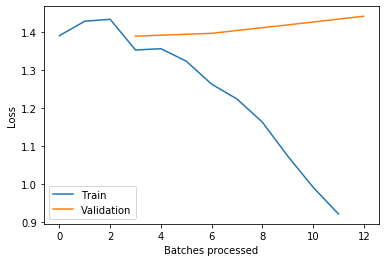

In [160]:
learner.recorder.plot_losses()

In [161]:
learner = Learner(data, make_model(), loss_func=F.cross_entropy, metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 3.63E-04


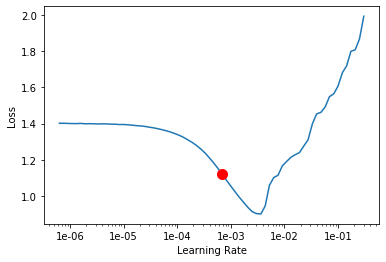

In [162]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [163]:
learner.fit_fc(4, lr=7e-4)

In [164]:
learner.fit_fc(100, lr=7e-4)

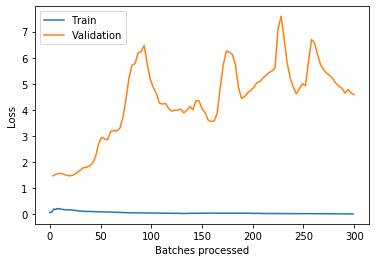

In [165]:
learner.recorder.plot_losses()

Lol.
That's some sweet overfitting.

My thoughts are that the difference in size is a huge problem.
The size of the dataset is also another big problem.
I'm going to try randomly generating mazes - they will be considered valid if they have a path from the pony to the end.

In [198]:
def random_mazes() -> Iterator[Tuple[torch.Tensor, int]]:
    while True:
        maze = _processed_maze()
        if maze:
            yield maze

def _processed_maze() -> Optional[Tuple[torch.Tensor, int]]:
    maze, width, pony, end = _random_maze()
    G = maze_to_graph(maze)
    try:
        idx_steps = nx.astar_path(G, pony, end)
    except:
        return None

    direction = DIRECTION_TO_IDX[to_direction(idx_steps[0], idx_steps[1], width)]
    return [maze_to_tensor(maze), direction]

def _random_maze() -> Tuple[torch.Tensor, int]:
    width = 25
    height = 25
    pony, enemy, end = random.sample(range(25 * 25), k=3)
    
    return {
        "pony": [pony],
        "domokun": [enemy],
        "end-point": [end],
        "size": [width, height],
        "difficulty": 0,
        "data": [
            random.choice([["west"], []]) + random.choice([["north"], []])
            for _ in range(width * height)
        ]
    }, width, pony, end

In [199]:
next(random_mazes())[0].shape

torch.Size([6, 49, 49])

In [200]:
class MazeDataset(Dataset):
    @staticmethod
    def random(count: int) -> ArrayDataset:
        data = []
        labels = []
        for (maze, label), _ in zip(random_mazes(), range(count)):
            data.append(maze)
            labels.append(label)
        return ArrayDataset(data, labels)
    
    def __init__(self, x: List[torch.Tensor], y: List[int]):
        self.x, self.y = x, y
        self.classes = sorted(set(y))
        self.c = len(self.classes)
    
    def __len__(self) -> int:
        return len(self.x)
    
    def __getitem__(self, i) -> Tuple[torch.Tensor, int]:
        return self.x[i], self.y[i]
    
    def __repr__(self):
        return f"ArrayDataset(x.shape={self.x[0].shape}, c={self.c}, classes={self.classes})"

In [201]:
data = DataBunch.create(MazeDataset.random(10_000), MazeDataset.random(1_000))

In [202]:
learner = Learner(data, make_model(), loss_func=F.cross_entropy, metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 5.75E-05


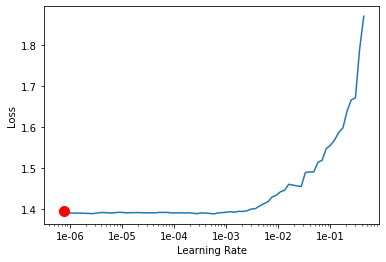

In [203]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [204]:
learner.fit_fc(4, lr=3e-4)

Well this has still gone badly. Heh.

So I don't really think this is representative - the mazes are likely to be much more open than the real ones, and they certainly permit cycles.
I could use the augmentation approach I originally outlined - changing the position of the exit / enemy / pony over an existing maze.
This was fun though.